复制

In [ ]:
import moxing as mox
 
mox.file.copy_parallel('obs://modelsarts-eric/MNIST_Data/', '/home/ma-user/work')

INFO:root:Using MoXing-v2.1.0.5d9c87c8-5d9c87c8
INFO:root:Using OBS-Python-SDK-3.20.9.1


训练部分

In [3]:
! rm -rf  checkpoint

rm: invalid option -- 'a'
Try 'rm --help' for more information.


In [1]:
import mindspore as ms
from mindspore import nn, context, Model, load_checkpoint, load_param_into_net
import mindspore.dataset.vision.c_transforms as CV
import mindspore.dataset.transforms.c_transforms as C
from mindspore.train.callback import LossMonitor, ModelCheckpoint, CheckpointConfig
from mindspore.common.initializer import initializer, Normal
import matplotlib.pyplot as plt
import matplotlib
import os
import numpy as np

context.set_context(mode=context.GRAPH_MODE, device_target='GPU')

def visualize(dataset):
    figure = plt.figure(figsize=(4, 4))
    cols, rows = 3, 3

    for idx, (image, label) in enumerate(dataset.create_tuple_iterator()):
        figure.add_subplot(rows, cols, idx + 1)
        plt.title(int(label))
        plt.axis("off")
        plt.imshow(image.asnumpy().squeeze(), cmap="gray")
        if idx == cols * rows - 1:
            break
    plt.show()


def MnistDataset(data_dir, batch_size=256, resize=(28, 28),
                 rescale=1 / (255 * 0.3081), shift=-0.1307 / 0.3081, buffer_size=64):
    ds = ms.dataset.MnistDataset(data_dir)
    ds = ds.map(input_columns=["image"], operations=[CV.Resize(resize), CV.Rescale(rescale, shift), CV.HWC2CHW()])
    ds = ds.map(input_columns=["label"], operations=C.TypeCast(ms.int32))
    ds = ds.shuffle(buffer_size=buffer_size).batch(batch_size, drop_remainder=True)
    return ds


class Network(nn.Cell):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dense_relu_sequential = nn.SequentialCell(
            nn.Dense(28 * 28, 512),
            nn.ReLU(),
            nn.Dense(512, 512),
            nn.ReLU(),
            nn.Dense(512, 10)
        )

    def construct(self, x):
        x = self.flatten(x)
        logits = self.dense_relu_sequential(x)
        return logits


num_epochs, lr = 100, 5e-3

data_train = MnistDataset("./MNIST_Data/train")
data_test = MnistDataset("./MNIST_Data/test")
net = Network()


loss = nn.loss.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
opt = nn.SGD(net.trainable_params(), lr)
loss_cb = LossMonitor(per_print_times=data_train.get_dataset_size())

model = Model(net, loss, opt, metrics={'acc', 'loss'})

model_path = "./checkpoint/"
config_ck = CheckpointConfig(save_checkpoint_steps=data_train.get_dataset_size(), keep_checkpoint_max=100)
ckpoint_cb = ModelCheckpoint(prefix="checkpoint_net", directory=model_path, config=config_ck)

model.train(num_epochs, data_train, callbacks=[loss_cb, ckpoint_cb], dataset_sink_mode=False)

metrics = model.eval(data_test, dataset_sink_mode=False)
print('Metrics:', metrics)


epoch: 1 step: 234, loss is 2.2831099033355713
epoch: 2 step: 234, loss is 2.2322285175323486
epoch: 3 step: 234, loss is 2.0499825477600098
epoch: 4 step: 234, loss is 1.59486985206604
epoch: 5 step: 234, loss is 0.989464521408081
epoch: 6 step: 234, loss is 0.7650231719017029
epoch: 7 step: 234, loss is 0.6758593320846558
epoch: 8 step: 234, loss is 0.504134476184845
epoch: 9 step: 234, loss is 0.4700089991092682
epoch: 10 step: 234, loss is 0.470613569021225
epoch: 11 step: 234, loss is 0.3997555673122406
epoch: 12 step: 234, loss is 0.4933946132659912
epoch: 13 step: 234, loss is 0.45921000838279724
epoch: 14 step: 234, loss is 0.31594592332839966
epoch: 15 step: 234, loss is 0.36113864183425903
epoch: 16 step: 234, loss is 0.2970486283302307
epoch: 17 step: 234, loss is 0.2787116467952728
epoch: 18 step: 234, loss is 0.2598998546600342
epoch: 19 step: 234, loss is 0.3289353549480438
epoch: 20 step: 234, loss is 0.3706319034099579
epoch: 21 step: 234, loss is 0.3229807913303375
epo

预测

Row 2, column 3 is incorrectly identified as 8, the correct value should be 2 



ValueError: num must be 1 <= num <= 32, not 33

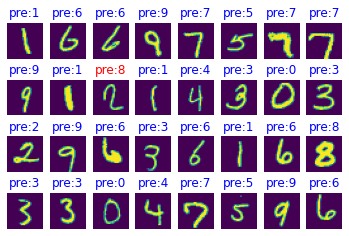

In [2]:
from mindspore import load_checkpoint, load_param_into_net
from mindspore import Tensor

ds_test = data_test.create_dict_iterator()
data = next(ds_test)
images = data["image"].asnumpy()
labels = data["label"].asnumpy()

param_dict = load_checkpoint("./checkpoint/checkpoint_net-98_234.ckpt")
net = Network()
load_param_into_net(net, param_dict)
model = Model(net, loss, opt, metrics={'acc', 'loss'})

output = model.predict(Tensor(data['image']))

pred = np.argmax(output.asnumpy(), axis=1)
err_num = []
index = 1
for i in range(len(labels)):
    plt.subplot(4, 8, i+1)
    color = 'blue' if pred[i] == labels[i] else 'red'
    plt.title("pre:{}".format(pred[i]), color=color)
    plt.imshow(np.squeeze(images[i]))
    plt.axis("off")
    if color == 'red':
        index = 0
        print("Row {}, column {} is incorrectly identified as {}, the correct value should be {}".format(int(i/8)+1, i%8+1, pred[i], labels[i]), '\n')
if index:
    print("All the figures in this group are predicted correctly!")
print(pred, "<--Predicted figures")
print(labels, "<--The right number")
plt.show()
